## RNN for Human Activity Recognition - 2D Pose Input

This experiment is the classification of human activities using a 2D pose time series dataset and an LSTM RNN.
The idea is to prove the concept that using a series of 2D poses, rather than 3D poses or a raw 2D images, can produce an accurate estimation of the behaviour of a person or animal.
This is a step towards creating a method of classifying an animal's current behaviour state and predicting it's likely next state, allowing for better interaction with an autonomous mobile robot.

## Objectives

The aims of this experiment are:

-  To determine if 2D pose has comparable accuracy to 3D pose for use in activity recognition. This would allow the use of RGB only cameras for human and animal pose estimation, as opposed to RGBD or a large motion capture dataset.


- To determine if  2D pose has comparable accuracy to using raw RGB images for use in activity recognition. This is based on the idea that limiting the input feature vector can help to deal with a limited dataset, as is likely to occur in animal activity recognition, by allowing for a smaller model to be used (citation required).


- To verify the concept for use in future works involving behaviour prediction from motion in 2D images.

The network used in this experiment is based on that of Guillaume Chevalier, 'LSTMs for Human Activity Recognition, 2016'  https://github.com/guillaume-chevalier/LSTM-Human-Activity-Recognition, available under the MIT License.
Notable changes that have been made (other than accounting for dataset sizes) are:
 - Adapting for use with a large dataset ordered by class, using random sampling without replacement for mini-batch.  
 This allows for use of smaller batch sizes when using a dataset ordered by class. "It has been observed in practice that when using a larger batch there is a significant degradation in the quality of the model, as measured by its ability to generalize"  
      _N.S Keskar, D. Mudigere, et al, 'On Large-Batch Training for Deep Learning: Generalization Gap and Sharp 
      Minima', ICLR 2017_ https://arxiv.org/abs/1609.04836
      
 - Exponentially decaying learning rate implemented



## Dataset overview

The dataset consists of pose estimations, made using the software OpenPose (https://github.com/CMU-Perceptual-Computing-Lab/openpose's) on a subset of the Berkeley Multimodal Human Action Database (MHAD) dataset http://tele-immersion.citris-uc.org/berkeley_mhad.

This dataset is comprised of 12 subjects doing the following 6 actions for 5 repetitions, filmed from 4 angles, repeated 5 times each.  

- JUMPING,
- JUMPING_JACKS,
- BOXING,
- WAVING_2HANDS,
- WAVING_1HAND,
- CLAPPING_HANDS.

In total, there are 1438 videos (2 were missing) made up of 211200 individual frames.

The below image is an example of the 4 camera views during the 'boxing' action for subject 1

![alt text](images/boxing_all_views.gif.png "Title")

The input for the LSTM is the 2D position of 18 joints across a timeseries of frames numbering n_steps (window-width), with an associated class label for the frame series.  
A single frame's input (where j refers to a joint) is stored as:

[  j0_x,  j0_y, j1_x, j1_y , j2_x, j2_y, j3_x, j3_y, j4_x, j4_y, j5_x, j5_y, j6_x, j6_y, j7_x, j7_y, j8_x, j8_y, j9_x, j9_y, j10_x, j10_y, j11_x, j11_y, j12_x, j12_y, j13_x, j13_y, j14_x, j14_y, j15_x, j15_y, j16_x, j16_y, j17_x, j17_y ]

For the following experiment, very little preprocessing has been done to the dataset.  
The following steps were taken:
1. openpose run on individual frames, for each subject, action and view, outputting JSON of 18 joint x and y position keypoints and accuracies per frame
2. JSONs converted into txt format, keeping only x and y positions of each frame, action being performed during frame, and order of frames. This is used to create a database of associated activity class number and corresponding series of joint 2D positions
3. No further prepossessing was performed.  

In some cases, multiple people were detected in each frame, in which only the first detection was used.

The data has not been normalised with regards to subject position in the frame, motion across frame (if any), size of the subject, speed of action etc. It is essentially the raw 2D position of each joint viewed from a stationary camera.  
In many cases, individual joints were not located and a position of [0.0,0.0] was given for that joint

A summary of the dataset used for input is:

 - 211200 individual images 
 - n_steps = 32 frames (~=1.5s at 22Hz)
 - Images with noisy pose detection (detection of >=2 people) = 5132  
 - Training_split = 0.8
 - Overlap = 0.8125 (26 / 32) ie 26 frame overlap
   - Length X_train = 22625 * 32 frames
   - Length X_test = 5751 * 32 frames
   
Note that their is no overlap between test and train sets, which were seperated by activity repetition entirely, before creating the 26 of 32 frame overlap.




## Training and Results below: 
Training took approximately 4 mins running on a single GTX1080Ti, and was run for 22,000,000ish iterations with a batch size of 5000  (600 epochs)


In [1]:

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf  # Version 1.0.0 (some previous versions are used in past commits)
from sklearn import metrics
import random
from random import randint
import time
import os

## Preparing dataset:

In [2]:
# Useful Constants

# Output classes to learn how to classify
LABELS = [    
    "JUMPING",
    "JUMPING_JACKS",
    "BOXING",
    "WAVING_2HANDS",
    "WAVING_1HAND",
    "CLAPPING_HANDS"

] 
DATASET_PATH = "data/HAR_pose_activities/database/"

X_train_path = DATASET_PATH + "X_train.txt"
X_test_path = DATASET_PATH + "X_test.txt"

y_train_path = DATASET_PATH + "Y_train.txt"
y_test_path = DATASET_PATH + "Y_test.txt"

n_steps = 32 # 32 timesteps per series

In [3]:

# Load the networks inputs

def load_X(X_path):
    file = open(X_path, 'r')
    X_ = np.array(
        [elem for elem in [
            row.split(',') for row in file
        ]], 
        dtype=np.float32
    )
    file.close()
    blocks = int(len(X_) / n_steps)
    
    X_ = np.array(np.split(X_,blocks))

    return X_ 

# Load the networks outputs

def load_y(y_path):
    file = open(y_path, 'r')
    y_ = np.array(
        [elem for elem in [
            row.replace('  ', ' ').strip().split(' ') for row in file
        ]], 
        dtype=np.int32
    )
    file.close()
    
    # for 0-based indexing 
    return y_ - 1

X_train = load_X(X_train_path)
X_test = load_X(X_test_path)
#print X_test

y_train = load_y(y_train_path)
y_test = load_y(y_test_path)
# proof that it actually works for the skeptical: replace labelled classes with random classes to train on
#for i in range(len(y_train)):
#    y_train[i] = randint(0, 5)


## Set Parameters:


In [4]:
# Input Data 

training_data_count = len(X_train)  # 4519 training series (with 50% overlap between each serie)
test_data_count = len(X_test)  # 1197 test series
n_input = len(X_train[0][0])  # num input parameters per timestep

n_hidden = 34 # Hidden layer num of features
n_classes = 6 

#updated for learning-rate decay
# calculated as: decayed_learning_rate = learning_rate * decay_rate ^ (global_step / decay_steps)
decaying_learning_rate = True
learning_rate = 0.0025 #used if decaying_learning_rate set to False
init_learning_rate = 0.005
decay_rate = 0.96 #the base of the exponential in the decay
decay_steps = 100000 #used in decay every 60000 steps with a base of 0.96

global_step = tf.Variable(0, trainable=False)
lambda_loss_amount = 0.0015

training_iters = training_data_count *300  # Loop 300 times on the dataset, ie 300 epochs
batch_size = 512
display_iter = batch_size*8  # To show test set accuracy during training

print("(X shape, y shape, every X's mean, every X's standard deviation)")
print(X_train.shape, y_test.shape, np.mean(X_test), np.std(X_test))
print("\nThe dataset has not been preprocessed, is not normalised etc")




(X shape, y shape, every X's mean, every X's standard deviation)
((22625, 32, 36), (5751, 1), 251.01117, 126.12204)

The dataset has not been preprocessed, is not normalised etc


## Utility functions for training:

In [5]:
def LSTM_RNN(_X, _weights, _biases):
    # model architecture based on "guillaume-chevalier" and "aymericdamien" under the MIT license.

    _X = tf.transpose(_X, [1, 0, 2])  # permute n_steps and batch_size
    _X = tf.reshape(_X, [-1, n_input])   
    # Rectifies Linear Unit activation function used
    _X = tf.nn.relu(tf.matmul(_X, _weights['hidden']) + _biases['hidden'])
    # Split data because rnn cell needs a list of inputs for the RNN inner loop
    _X = tf.split(_X, n_steps, 0) 

    # Define two stacked LSTM cells (two recurrent layers deep) with tensorflow
    lstm_cell_1 = tf.contrib.rnn.BasicLSTMCell(n_hidden, forget_bias=1.0, state_is_tuple=True)
    lstm_cell_2 = tf.contrib.rnn.BasicLSTMCell(n_hidden, forget_bias=1.0, state_is_tuple=True)
    lstm_cells = tf.contrib.rnn.MultiRNNCell([lstm_cell_1, lstm_cell_2], state_is_tuple=True)
    outputs, states = tf.contrib.rnn.static_rnn(lstm_cells, _X, dtype=tf.float32)

    # A single output is produced, in style of "many to one" classifier, refer to http://karpathy.github.io/2015/05/21/rnn-effectiveness/ for details
    lstm_last_output = outputs[-1]
    
    # Linear activation
    return tf.matmul(lstm_last_output, _weights['out']) + _biases['out']


def extract_batch_size(_train, _labels, _unsampled, batch_size):
    # Fetch a "batch_size" amount of data and labels from "(X|y)_train" data. 
    # Elements of each batch are chosen randomly, without replacement, from X_train with corresponding label from Y_train
    # unsampled_indices keeps track of sampled data ensuring non-replacement. Resets when remaining datapoints < batch_size    
    
    shape = list(_train.shape)
    shape[0] = batch_size
    batch_s = np.empty(shape)
    batch_labels = np.empty((batch_size,1)) 

    for i in range(batch_size):
        # Loop index
        # index = random sample from _unsampled (indices)
        index = random.choice(_unsampled)
        batch_s[i] = _train[index] 
        batch_labels[i] = _labels[index]
        _unsampled.remove(index)


    return batch_s, batch_labels, _unsampled


def one_hot(y_):
    # One hot encoding of the network outputs
    # e.g.: [[5], [0], [3]] --> [[0, 0, 0, 0, 0, 1], [1, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0]]
    
    y_ = y_.reshape(len(y_))
    n_values = int(np.max(y_)) + 1
    return np.eye(n_values)[np.array(y_, dtype=np.int32)]  # Returns FLOATS



## Build the network:

In [6]:

# Graph input/output
x = tf.placeholder(tf.float32, [None, n_steps, n_input])
y = tf.placeholder(tf.float32, [None, n_classes])

# Graph weights
weights = {
    'hidden': tf.Variable(tf.random_normal([n_input, n_hidden])), # Hidden layer weights
    'out': tf.Variable(tf.random_normal([n_hidden, n_classes], mean=1.0))
}
biases = {
    'hidden': tf.Variable(tf.random_normal([n_hidden])),
    'out': tf.Variable(tf.random_normal([n_classes]))
}

pred = LSTM_RNN(x, weights, biases)

# Loss, optimizer and evaluation
l2 = lambda_loss_amount * sum(
    tf.nn.l2_loss(tf_var) for tf_var in tf.trainable_variables()
) # L2 loss prevents this overkill neural network to overfit the data
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=pred)) + l2 # Softmax loss
if decaying_learning_rate:
    learning_rate = tf.train.exponential_decay(init_learning_rate, global_step*batch_size, decay_steps, decay_rate, staircase=True)


#decayed_learning_rate = learning_rate * decay_rate ^ (global_step / decay_steps) #exponentially decayed learning rate
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost,global_step=global_step) # Adam Optimizer

correct_pred = tf.equal(tf.argmax(pred,1), tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))



## Train the network:

In [7]:
test_losses = []
test_accuracies = []
train_losses = []
train_accuracies = []
sess = tf.InteractiveSession(config=tf.ConfigProto(log_device_placement=True))
init = tf.global_variables_initializer()
sess.run(init)

# Perform Training steps with "batch_size" amount of data at each loop. 
# Elements of each batch are chosen randomly, without replacement, from X_train, 
# restarting when remaining datapoints < batch_size
step = 1
time_start = time.time()
unsampled_indices = range(0,len(X_train))

while step * batch_size <= training_iters:
    #print (sess.run(learning_rate)) #decaying learning rate
    #print (sess.run(global_step)) # global number of iterations
    if len(unsampled_indices) < batch_size:
        unsampled_indices = range(0,len(X_train)) 
    batch_xs, raw_labels, unsampled_indicies = extract_batch_size(X_train, y_train, unsampled_indices, batch_size)
    batch_ys = one_hot(raw_labels)
    # check that encoded output is same length as num_classes, if not, pad it 
    if len(batch_ys[0]) < n_classes:
        temp_ys = np.zeros((batch_size, n_classes))
        temp_ys[:batch_ys.shape[0],:batch_ys.shape[1]] = batch_ys
        batch_ys = temp_ys
       
    

    # Fit training using batch data
    _, loss, acc = sess.run(
        [optimizer, cost, accuracy],
        feed_dict={
            x: batch_xs, 
            y: batch_ys
        }
    )
    train_losses.append(loss)
    train_accuracies.append(acc)
    
    # Evaluate network only at some steps for faster training: 
    if (step*batch_size % display_iter == 0) or (step == 1) or (step * batch_size > training_iters):
        
        # To not spam console, show training accuracy/loss in this "if"
        print("Iter #" + str(step*batch_size) + \
              ":  Learning rate = " + "{:.6f}".format(sess.run(learning_rate)) + \
              ":   Batch Loss = " + "{:.6f}".format(loss) + \
              ", Accuracy = {}".format(acc))
        
        # Evaluation on the test set (no learning made here - just evaluation for diagnosis)
        loss, acc = sess.run(
            [cost, accuracy], 
            feed_dict={
                x: X_test,
                y: one_hot(y_test)
            }
        )
        test_losses.append(loss)
        test_accuracies.append(acc)
        print("PERFORMANCE ON TEST SET:             " + \
              "Batch Loss = {}".format(loss) + \
              ", Accuracy = {}".format(acc))

    step += 1

print("Optimization Finished!")

# Accuracy for test data

one_hot_predictions, accuracy, final_loss = sess.run(
    [pred, accuracy, cost],
    feed_dict={
        x: X_test,
        y: one_hot(y_test)
    }
)

test_losses.append(final_loss)
test_accuracies.append(accuracy)

print("FINAL RESULT: " + \
      "Batch Loss = {}".format(final_loss) + \
      ", Accuracy = {}".format(accuracy))
time_stop = time.time()
print("TOTAL TIME:  {}".format(time_stop - time_start))

Iter #512:  Learning rate = 0.005000:   Batch Loss = 4.315274, Accuracy = 0.15234375
PERFORMANCE ON TEST SET:             Batch Loss = 3.68809938431, Accuracy = 0.205529466271
Iter #4096:  Learning rate = 0.005000:   Batch Loss = 3.057283, Accuracy = 0.263671875
PERFORMANCE ON TEST SET:             Batch Loss = 3.04467487335, Accuracy = 0.262215256691
Iter #8192:  Learning rate = 0.005000:   Batch Loss = 2.814128, Accuracy = 0.345703125
PERFORMANCE ON TEST SET:             Batch Loss = 2.78404188156, Accuracy = 0.383933216333
Iter #12288:  Learning rate = 0.005000:   Batch Loss = 2.682125, Accuracy = 0.44921875
PERFORMANCE ON TEST SET:             Batch Loss = 2.71795201302, Accuracy = 0.407233536243
Iter #16384:  Learning rate = 0.005000:   Batch Loss = 2.361879, Accuracy = 0.5
PERFORMANCE ON TEST SET:             Batch Loss = 2.44809341431, Accuracy = 0.497652590275
Iter #20480:  Learning rate = 0.005000:   Batch Loss = 2.457385, Accuracy = 0.482421875
PERFORMANCE ON TEST SET:       

Iter #192512:  Learning rate = 0.004800:   Batch Loss = 1.225653, Accuracy = 0.86328125
PERFORMANCE ON TEST SET:             Batch Loss = 1.24891602993, Accuracy = 0.837245702744
Iter #196608:  Learning rate = 0.004800:   Batch Loss = 1.140967, Accuracy = 0.912109375
PERFORMANCE ON TEST SET:             Batch Loss = 1.26040267944, Accuracy = 0.833246409893
Iter #200704:  Learning rate = 0.004608:   Batch Loss = 1.196584, Accuracy = 0.865234375
PERFORMANCE ON TEST SET:             Batch Loss = 1.26048076153, Accuracy = 0.827682137489
Iter #204800:  Learning rate = 0.004608:   Batch Loss = 1.271167, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 1.22448432446, Accuracy = 0.839853942394
Iter #208896:  Learning rate = 0.004608:   Batch Loss = 1.182554, Accuracy = 0.861328125
PERFORMANCE ON TEST SET:             Batch Loss = 1.24009859562, Accuracy = 0.828377664089
Iter #212992:  Learning rate = 0.004608:   Batch Loss = 1.229189, Accuracy = 0.849609375
PERFORMANCE ON TE

Iter #380928:  Learning rate = 0.004424:   Batch Loss = 0.952235, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.952122449875, Accuracy = 0.900712907314
Iter #385024:  Learning rate = 0.004424:   Batch Loss = 0.912896, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 1.00123631954, Accuracy = 0.877586483955
Iter #389120:  Learning rate = 0.004424:   Batch Loss = 0.947593, Accuracy = 0.89453125
PERFORMANCE ON TEST SET:             Batch Loss = 0.96993792057, Accuracy = 0.891497135162
Iter #393216:  Learning rate = 0.004424:   Batch Loss = 0.968514, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.956546664238, Accuracy = 0.896539747715
Iter #397312:  Learning rate = 0.004424:   Batch Loss = 0.961573, Accuracy = 0.896484375
PERFORMANCE ON TEST SET:             Batch Loss = 0.978764533997, Accuracy = 0.888019502163
Iter #401408:  Learning rate = 0.004247:   Batch Loss = 0.991264, Accuracy = 0.880859375
PERFORMANCE ON TEST 

Iter #569344:  Learning rate = 0.004077:   Batch Loss = 0.991116, Accuracy = 0.8828125
PERFORMANCE ON TEST SET:             Batch Loss = 1.09497725964, Accuracy = 0.833420276642
Iter #573440:  Learning rate = 0.004077:   Batch Loss = 0.894690, Accuracy = 0.892578125
PERFORMANCE ON TEST SET:             Batch Loss = 0.909497261047, Accuracy = 0.886976182461
Iter #577536:  Learning rate = 0.004077:   Batch Loss = 0.892936, Accuracy = 0.892578125
PERFORMANCE ON TEST SET:             Batch Loss = 0.896346211433, Accuracy = 0.895496428013
Iter #581632:  Learning rate = 0.004077:   Batch Loss = 0.945477, Accuracy = 0.880859375
PERFORMANCE ON TEST SET:             Batch Loss = 0.909026503563, Accuracy = 0.88436794281
Iter #585728:  Learning rate = 0.004077:   Batch Loss = 0.863998, Accuracy = 0.900390625
PERFORMANCE ON TEST SET:             Batch Loss = 0.860609829426, Accuracy = 0.899321854115
Iter #589824:  Learning rate = 0.004077:   Batch Loss = 0.894184, Accuracy = 0.90234375
PERFORMANCE

Iter #757760:  Learning rate = 0.003757:   Batch Loss = 0.825089, Accuracy = 0.91015625
PERFORMANCE ON TEST SET:             Batch Loss = 1.04161834717, Accuracy = 0.845592081547
Iter #761856:  Learning rate = 0.003757:   Batch Loss = 0.950108, Accuracy = 0.857421875
PERFORMANCE ON TEST SET:             Batch Loss = 1.06441175938, Accuracy = 0.804729640484
Iter #765952:  Learning rate = 0.003757:   Batch Loss = 0.832553, Accuracy = 0.884765625
PERFORMANCE ON TEST SET:             Batch Loss = 0.85548722744, Accuracy = 0.88036864996
Iter #770048:  Learning rate = 0.003757:   Batch Loss = 0.810594, Accuracy = 0.91015625
PERFORMANCE ON TEST SET:             Batch Loss = 0.807729482651, Accuracy = 0.895670294762
Iter #774144:  Learning rate = 0.003757:   Batch Loss = 0.757618, Accuracy = 0.94140625
PERFORMANCE ON TEST SET:             Batch Loss = 0.793379187584, Accuracy = 0.912015318871
Iter #778240:  Learning rate = 0.003757:   Batch Loss = 0.780720, Accuracy = 0.91796875
PERFORMANCE ON

Iter #946176:  Learning rate = 0.003463:   Batch Loss = 0.695094, Accuracy = 0.94140625
PERFORMANCE ON TEST SET:             Batch Loss = 0.720028996468, Accuracy = 0.935315608978
Iter #950272:  Learning rate = 0.003463:   Batch Loss = 0.674766, Accuracy = 0.943359375
PERFORMANCE ON TEST SET:             Batch Loss = 0.738963782787, Accuracy = 0.91479742527
Iter #954368:  Learning rate = 0.003463:   Batch Loss = 0.699598, Accuracy = 0.931640625
PERFORMANCE ON TEST SET:             Batch Loss = 0.76727950573, Accuracy = 0.903321146965
Iter #958464:  Learning rate = 0.003463:   Batch Loss = 0.694827, Accuracy = 0.94140625
PERFORMANCE ON TEST SET:             Batch Loss = 0.746849179268, Accuracy = 0.91410189867
Iter #962560:  Learning rate = 0.003463:   Batch Loss = 0.965101, Accuracy = 0.837890625
PERFORMANCE ON TEST SET:             Batch Loss = 0.943105757236, Accuracy = 0.843331575394
Iter #966656:  Learning rate = 0.003463:   Batch Loss = 0.896669, Accuracy = 0.876953125
PERFORMANCE

Iter #1134592:  Learning rate = 0.003191:   Batch Loss = 0.709217, Accuracy = 0.927734375
PERFORMANCE ON TEST SET:             Batch Loss = 0.759344220161, Accuracy = 0.904538333416
Iter #1138688:  Learning rate = 0.003191:   Batch Loss = 0.682504, Accuracy = 0.931640625
PERFORMANCE ON TEST SET:             Batch Loss = 0.69336616993, Accuracy = 0.923665463924
Iter #1142784:  Learning rate = 0.003191:   Batch Loss = 0.670215, Accuracy = 0.923828125
PERFORMANCE ON TEST SET:             Batch Loss = 0.728442549706, Accuracy = 0.911841392517
Iter #1146880:  Learning rate = 0.003191:   Batch Loss = 0.646213, Accuracy = 0.9453125
PERFORMANCE ON TEST SET:             Batch Loss = 0.734402477741, Accuracy = 0.90801602602
Iter #1150976:  Learning rate = 0.003191:   Batch Loss = 0.661416, Accuracy = 0.935546875
PERFORMANCE ON TEST SET:             Batch Loss = 2.62763786316, Accuracy = 0.525126039982
Iter #1155072:  Learning rate = 0.003191:   Batch Loss = 1.082134, Accuracy = 0.732421875
PERFO

Iter #1323008:  Learning rate = 0.002941:   Batch Loss = 0.616287, Accuracy = 0.955078125
PERFORMANCE ON TEST SET:             Batch Loss = 0.675169110298, Accuracy = 0.934098422527
Iter #1327104:  Learning rate = 0.002941:   Batch Loss = 0.689656, Accuracy = 0.91796875
PERFORMANCE ON TEST SET:             Batch Loss = 0.707977592945, Accuracy = 0.91479742527
Iter #1331200:  Learning rate = 0.002941:   Batch Loss = 0.647947, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.664164304733, Accuracy = 0.930446863174
Iter #1335296:  Learning rate = 0.002941:   Batch Loss = 0.677020, Accuracy = 0.9296875
PERFORMANCE ON TEST SET:             Batch Loss = 0.699986159801, Accuracy = 0.916710138321
Iter #1339392:  Learning rate = 0.002941:   Batch Loss = 0.636646, Accuracy = 0.94140625
PERFORMANCE ON TEST SET:             Batch Loss = 0.783833622932, Accuracy = 0.881585836411
Iter #1343488:  Learning rate = 0.002941:   Batch Loss = 0.699503, Accuracy = 0.916015625
PERFORMANC

Iter #1511424:  Learning rate = 0.002710:   Batch Loss = 0.580128, Accuracy = 0.96484375
PERFORMANCE ON TEST SET:             Batch Loss = 0.653562903404, Accuracy = 0.937228322029
Iter #1515520:  Learning rate = 0.002710:   Batch Loss = 0.619445, Accuracy = 0.935546875
PERFORMANCE ON TEST SET:             Batch Loss = 0.644525885582, Accuracy = 0.928881943226
Iter #1519616:  Learning rate = 0.002710:   Batch Loss = 0.625973, Accuracy = 0.939453125
PERFORMANCE ON TEST SET:             Batch Loss = 0.699604988098, Accuracy = 0.917927324772
Iter #1523712:  Learning rate = 0.002710:   Batch Loss = 0.634093, Accuracy = 0.931640625
PERFORMANCE ON TEST SET:             Batch Loss = 0.670182347298, Accuracy = 0.92088329792
Iter #1527808:  Learning rate = 0.002710:   Batch Loss = 0.632183, Accuracy = 0.94921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.614475011826, Accuracy = 0.948356807232
Iter #1531904:  Learning rate = 0.002710:   Batch Loss = 0.582478, Accuracy = 0.953125
PERFOR

Iter #1699840:  Learning rate = 0.002602:   Batch Loss = 0.590384, Accuracy = 0.943359375
PERFORMANCE ON TEST SET:             Batch Loss = 0.617018222809, Accuracy = 0.938793241978
Iter #1703936:  Learning rate = 0.002498:   Batch Loss = 0.584574, Accuracy = 0.947265625
PERFORMANCE ON TEST SET:             Batch Loss = 0.618707597256, Accuracy = 0.928708076477
Iter #1708032:  Learning rate = 0.002498:   Batch Loss = 0.560328, Accuracy = 0.962890625
PERFORMANCE ON TEST SET:             Batch Loss = 0.635425329208, Accuracy = 0.922622144222
Iter #1712128:  Learning rate = 0.002498:   Batch Loss = 0.530334, Accuracy = 0.974609375
PERFORMANCE ON TEST SET:             Batch Loss = 0.629549503326, Accuracy = 0.930620789528
Iter #1716224:  Learning rate = 0.002498:   Batch Loss = 0.566467, Accuracy = 0.962890625
PERFORMANCE ON TEST SET:             Batch Loss = 0.620246112347, Accuracy = 0.932707369328
Iter #1720320:  Learning rate = 0.002498:   Batch Loss = 0.533980, Accuracy = 0.96875
PERF

Iter #1888256:  Learning rate = 0.002398:   Batch Loss = 0.610111, Accuracy = 0.923828125
PERFORMANCE ON TEST SET:             Batch Loss = 0.654805660248, Accuracy = 0.911667525768
Iter #1892352:  Learning rate = 0.002398:   Batch Loss = 0.565088, Accuracy = 0.955078125
PERFORMANCE ON TEST SET:             Batch Loss = 0.582720398903, Accuracy = 0.942618668079
Iter #1896448:  Learning rate = 0.002398:   Batch Loss = 0.569994, Accuracy = 0.943359375
PERFORMANCE ON TEST SET:             Batch Loss = 0.614137649536, Accuracy = 0.929577469826
Iter #1900544:  Learning rate = 0.002302:   Batch Loss = 0.616385, Accuracy = 0.9296875
PERFORMANCE ON TEST SET:             Batch Loss = 0.642225801945, Accuracy = 0.913058578968
Iter #1904640:  Learning rate = 0.002302:   Batch Loss = 0.560796, Accuracy = 0.947265625
PERFORMANCE ON TEST SET:             Batch Loss = 0.667030155659, Accuracy = 0.908885419369
Iter #1908736:  Learning rate = 0.002302:   Batch Loss = 0.614530, Accuracy = 0.923828125
PE

Iter #2076672:  Learning rate = 0.002210:   Batch Loss = 0.515174, Accuracy = 0.962890625
PERFORMANCE ON TEST SET:             Batch Loss = 0.559347510338, Accuracy = 0.945400774479
Iter #2080768:  Learning rate = 0.002210:   Batch Loss = 0.504331, Accuracy = 0.96484375
PERFORMANCE ON TEST SET:             Batch Loss = 0.582437455654, Accuracy = 0.932359576225
Iter #2084864:  Learning rate = 0.002210:   Batch Loss = 0.490880, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.570172429085, Accuracy = 0.941575407982
Iter #2088960:  Learning rate = 0.002210:   Batch Loss = 0.595497, Accuracy = 0.935546875
PERFORMANCE ON TEST SET:             Batch Loss = 0.548255860806, Accuracy = 0.947835147381
Iter #2093056:  Learning rate = 0.002210:   Batch Loss = 0.485689, Accuracy = 0.970703125
PERFORMANCE ON TEST SET:             Batch Loss = 0.558807730675, Accuracy = 0.942097008228
Iter #2097152:  Learning rate = 0.002210:   Batch Loss = 0.487676, Accuracy = 0.966796875
PERFO

Iter #2265088:  Learning rate = 0.002037:   Batch Loss = 0.492740, Accuracy = 0.96484375
PERFORMANCE ON TEST SET:             Batch Loss = 0.544739305973, Accuracy = 0.943661987782
Iter #2269184:  Learning rate = 0.002037:   Batch Loss = 0.479516, Accuracy = 0.98046875
PERFORMANCE ON TEST SET:             Batch Loss = 0.556976556778, Accuracy = 0.940358221531
Iter #2273280:  Learning rate = 0.002037:   Batch Loss = 0.523295, Accuracy = 0.96484375
PERFORMANCE ON TEST SET:             Batch Loss = 0.553324222565, Accuracy = 0.939488768578
Iter #2277376:  Learning rate = 0.002037:   Batch Loss = 0.541209, Accuracy = 0.94921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.585600197315, Accuracy = 0.934272289276
Iter #2281472:  Learning rate = 0.002037:   Batch Loss = 0.524233, Accuracy = 0.94921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.619158744812, Accuracy = 0.921057224274
Iter #2285568:  Learning rate = 0.002037:   Batch Loss = 0.475449, Accuracy = 0.9765625
PERFORM

Iter #2453504:  Learning rate = 0.001877:   Batch Loss = 0.481784, Accuracy = 0.962890625
PERFORMANCE ON TEST SET:             Batch Loss = 0.57051217556, Accuracy = 0.939662694931
Iter #2457600:  Learning rate = 0.001877:   Batch Loss = 0.533041, Accuracy = 0.94921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.560644388199, Accuracy = 0.936532795429
Iter #2461696:  Learning rate = 0.001877:   Batch Loss = 0.509439, Accuracy = 0.95703125
PERFORMANCE ON TEST SET:             Batch Loss = 0.553218126297, Accuracy = 0.938619375229
Iter #2465792:  Learning rate = 0.001877:   Batch Loss = 0.509301, Accuracy = 0.955078125
PERFORMANCE ON TEST SET:             Batch Loss = 0.551937460899, Accuracy = 0.93774998188
Iter #2469888:  Learning rate = 0.001877:   Batch Loss = 0.476438, Accuracy = 0.970703125
PERFORMANCE ON TEST SET:             Batch Loss = 0.532647490501, Accuracy = 0.943488061428
Iter #2473984:  Learning rate = 0.001877:   Batch Loss = 0.468486, Accuracy = 0.978515625
PERF

Iter #2641920:  Learning rate = 0.001730:   Batch Loss = 0.449749, Accuracy = 0.97265625
PERFORMANCE ON TEST SET:             Batch Loss = 0.491400450468, Accuracy = 0.957746505737
Iter #2646016:  Learning rate = 0.001730:   Batch Loss = 0.482257, Accuracy = 0.962890625
PERFORMANCE ON TEST SET:             Batch Loss = 0.499469041824, Accuracy = 0.952008366585
Iter #2650112:  Learning rate = 0.001730:   Batch Loss = 0.481181, Accuracy = 0.955078125
PERFORMANCE ON TEST SET:             Batch Loss = 0.528387784958, Accuracy = 0.940184295177
Iter #2654208:  Learning rate = 0.001730:   Batch Loss = 0.491371, Accuracy = 0.958984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6969653368, Accuracy = 0.897930800915
Iter #2658304:  Learning rate = 0.001730:   Batch Loss = 0.574480, Accuracy = 0.935546875
PERFORMANCE ON TEST SET:             Batch Loss = 0.630158185959, Accuracy = 0.902451753616
Iter #2662400:  Learning rate = 0.001730:   Batch Loss = 0.494103, Accuracy = 0.951171875
PER

Iter #2830336:  Learning rate = 0.001594:   Batch Loss = 0.460027, Accuracy = 0.96484375
PERFORMANCE ON TEST SET:             Batch Loss = 0.4905397892, Accuracy = 0.951486706734
Iter #2834432:  Learning rate = 0.001594:   Batch Loss = 0.480928, Accuracy = 0.962890625
PERFORMANCE ON TEST SET:             Batch Loss = 0.473301380873, Accuracy = 0.958963632584
Iter #2838528:  Learning rate = 0.001594:   Batch Loss = 0.459908, Accuracy = 0.974609375
PERFORMANCE ON TEST SET:             Batch Loss = 0.500727891922, Accuracy = 0.948878467083
Iter #2842624:  Learning rate = 0.001594:   Batch Loss = 0.445302, Accuracy = 0.970703125
PERFORMANCE ON TEST SET:             Batch Loss = 0.488423466682, Accuracy = 0.952703893185
Iter #2846720:  Learning rate = 0.001594:   Batch Loss = 0.458719, Accuracy = 0.970703125
PERFORMANCE ON TEST SET:             Batch Loss = 0.487469255924, Accuracy = 0.956007659435
Iter #2850816:  Learning rate = 0.001594:   Batch Loss = 0.452304, Accuracy = 0.96875
PERFORM

Iter #3018752:  Learning rate = 0.001469:   Batch Loss = 0.441309, Accuracy = 0.9765625
PERFORMANCE ON TEST SET:             Batch Loss = 0.500018954277, Accuracy = 0.953399419785
Iter #3022848:  Learning rate = 0.001469:   Batch Loss = 0.451621, Accuracy = 0.966796875
PERFORMANCE ON TEST SET:             Batch Loss = 0.52546197176, Accuracy = 0.941575407982
Iter #3026944:  Learning rate = 0.001469:   Batch Loss = 0.437203, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.496891796589, Accuracy = 0.952703893185
Iter #3031040:  Learning rate = 0.001469:   Batch Loss = 0.477103, Accuracy = 0.9609375
PERFORMANCE ON TEST SET:             Batch Loss = 0.520498812199, Accuracy = 0.940184295177
Iter #3035136:  Learning rate = 0.001469:   Batch Loss = 0.434293, Accuracy = 0.97265625
PERFORMANCE ON TEST SET:             Batch Loss = 0.508045911789, Accuracy = 0.946791887283
Iter #3039232:  Learning rate = 0.001469:   Batch Loss = 0.448360, Accuracy = 0.96484375
PERFORMANC

Iter #3207168:  Learning rate = 0.001354:   Batch Loss = 0.431710, Accuracy = 0.97265625
PERFORMANCE ON TEST SET:             Batch Loss = 0.492677360773, Accuracy = 0.954268813133
Iter #3211264:  Learning rate = 0.001354:   Batch Loss = 0.427776, Accuracy = 0.970703125
PERFORMANCE ON TEST SET:             Batch Loss = 0.478709936142, Accuracy = 0.950269520283
Iter #3215360:  Learning rate = 0.001354:   Batch Loss = 0.399400, Accuracy = 0.986328125
PERFORMANCE ON TEST SET:             Batch Loss = 0.478114843369, Accuracy = 0.954268813133
Iter #3219456:  Learning rate = 0.001354:   Batch Loss = 0.418675, Accuracy = 0.974609375
PERFORMANCE ON TEST SET:             Batch Loss = 0.477426290512, Accuracy = 0.956355392933
Iter #3223552:  Learning rate = 0.001354:   Batch Loss = 0.410471, Accuracy = 0.98046875
PERFORMANCE ON TEST SET:             Batch Loss = 0.477913290262, Accuracy = 0.953225553036
Iter #3227648:  Learning rate = 0.001354:   Batch Loss = 0.400962, Accuracy = 0.984375
PERFO

Iter #3395584:  Learning rate = 0.001300:   Batch Loss = 0.397809, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.450539380312, Accuracy = 0.962789058685
Iter #3399680:  Learning rate = 0.001300:   Batch Loss = 0.432379, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.488848567009, Accuracy = 0.947139620781
Iter #3403776:  Learning rate = 0.001248:   Batch Loss = 0.412279, Accuracy = 0.978515625
PERFORMANCE ON TEST SET:             Batch Loss = 0.439525395632, Accuracy = 0.964527904987
Iter #3407872:  Learning rate = 0.001248:   Batch Loss = 0.431976, Accuracy = 0.97265625
PERFORMANCE ON TEST SET:             Batch Loss = 0.445790886879, Accuracy = 0.964701771736
Iter #3411968:  Learning rate = 0.001248:   Batch Loss = 0.412835, Accuracy = 0.974609375
PERFORMANCE ON TEST SET:             Batch Loss = 0.494063675404, Accuracy = 0.946444094181
Iter #3416064:  Learning rate = 0.001248:   Batch Loss = 0.428705, Accuracy = 0.97265625
PERFORMAN

Iter #3584000:  Learning rate = 0.001198:   Batch Loss = 0.396957, Accuracy = 0.98046875
PERFORMANCE ON TEST SET:             Batch Loss = 0.443421810865, Accuracy = 0.963658511639
Iter #3588096:  Learning rate = 0.001198:   Batch Loss = 0.386240, Accuracy = 0.986328125
PERFORMANCE ON TEST SET:             Batch Loss = 0.444532692432, Accuracy = 0.962267458439
Iter #3592192:  Learning rate = 0.001198:   Batch Loss = 0.388991, Accuracy = 0.982421875
PERFORMANCE ON TEST SET:             Batch Loss = 0.434926390648, Accuracy = 0.963832378387
Iter #3596288:  Learning rate = 0.001198:   Batch Loss = 0.386139, Accuracy = 0.986328125
PERFORMANCE ON TEST SET:             Batch Loss = 0.43326702714, Accuracy = 0.964527904987
Iter #3600384:  Learning rate = 0.001150:   Batch Loss = 0.393312, Accuracy = 0.98046875
PERFORMANCE ON TEST SET:             Batch Loss = 0.437671124935, Accuracy = 0.964006245136
Iter #3604480:  Learning rate = 0.001150:   Batch Loss = 0.409384, Accuracy = 0.9765625
PERFO

Iter #3772416:  Learning rate = 0.001104:   Batch Loss = 0.363726, Accuracy = 0.990234375
PERFORMANCE ON TEST SET:             Batch Loss = 0.432309478521, Accuracy = 0.966440618038
Iter #3776512:  Learning rate = 0.001104:   Batch Loss = 0.404822, Accuracy = 0.9765625
PERFORMANCE ON TEST SET:             Batch Loss = 0.424257695675, Accuracy = 0.96487569809
Iter #3780608:  Learning rate = 0.001104:   Batch Loss = 0.393033, Accuracy = 0.978515625
PERFORMANCE ON TEST SET:             Batch Loss = 0.440357387066, Accuracy = 0.959833085537
Iter #3784704:  Learning rate = 0.001104:   Batch Loss = 0.400212, Accuracy = 0.974609375
PERFORMANCE ON TEST SET:             Batch Loss = 0.455943346024, Accuracy = 0.954268813133
Iter #3788800:  Learning rate = 0.001104:   Batch Loss = 0.397491, Accuracy = 0.9765625
PERFORMANCE ON TEST SET:             Batch Loss = 0.44909465313, Accuracy = 0.960006952286
Iter #3792896:  Learning rate = 0.001104:   Batch Loss = 0.393609, Accuracy = 0.9765625
PERFORMA

Iter #3960832:  Learning rate = 0.001018:   Batch Loss = 0.365578, Accuracy = 0.990234375
PERFORMANCE ON TEST SET:             Batch Loss = 0.418415546417, Accuracy = 0.967136144638
Iter #3964928:  Learning rate = 0.001018:   Batch Loss = 0.365543, Accuracy = 0.986328125
PERFORMANCE ON TEST SET:             Batch Loss = 0.402402490377, Accuracy = 0.971309363842
Iter #3969024:  Learning rate = 0.001018:   Batch Loss = 0.403500, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.472196280956, Accuracy = 0.94592243433
Iter #3973120:  Learning rate = 0.001018:   Batch Loss = 0.385263, Accuracy = 0.982421875
PERFORMANCE ON TEST SET:             Batch Loss = 0.434478491545, Accuracy = 0.961224138737
Iter #3977216:  Learning rate = 0.001018:   Batch Loss = 0.375830, Accuracy = 0.982421875
PERFORMANCE ON TEST SET:             Batch Loss = 0.424495220184, Accuracy = 0.96487569809
Iter #3981312:  Learning rate = 0.001018:   Batch Loss = 0.412971, Accuracy = 0.978515625
PERFOR

Iter #4149248:  Learning rate = 0.000938:   Batch Loss = 0.391943, Accuracy = 0.9765625
PERFORMANCE ON TEST SET:             Batch Loss = 0.446657419205, Accuracy = 0.957224845886
Iter #4153344:  Learning rate = 0.000938:   Batch Loss = 0.416779, Accuracy = 0.97265625
PERFORMANCE ON TEST SET:             Batch Loss = 0.459856510162, Accuracy = 0.955312132835
Iter #4157440:  Learning rate = 0.000938:   Batch Loss = 0.362991, Accuracy = 0.9921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.4347217381, Accuracy = 0.959833085537
Iter #4161536:  Learning rate = 0.000938:   Batch Loss = 0.363894, Accuracy = 0.990234375
PERFORMANCE ON TEST SET:             Batch Loss = 0.415193021297, Accuracy = 0.96418017149
Iter #4165632:  Learning rate = 0.000938:   Batch Loss = 0.376909, Accuracy = 0.990234375
PERFORMANCE ON TEST SET:             Batch Loss = 0.453539043665, Accuracy = 0.952182233334
Iter #4169728:  Learning rate = 0.000938:   Batch Loss = 0.366804, Accuracy = 0.990234375
PERFORMA

Iter #4337664:  Learning rate = 0.000864:   Batch Loss = 0.358813, Accuracy = 0.98828125
PERFORMANCE ON TEST SET:             Batch Loss = 0.408319741488, Accuracy = 0.965745091438
Iter #4341760:  Learning rate = 0.000864:   Batch Loss = 0.352763, Accuracy = 0.994140625
PERFORMANCE ON TEST SET:             Batch Loss = 0.40688893199, Accuracy = 0.968527197838
Iter #4345856:  Learning rate = 0.000864:   Batch Loss = 0.403462, Accuracy = 0.9765625
PERFORMANCE ON TEST SET:             Batch Loss = 0.42007419467, Accuracy = 0.96487569809
Iter #4349952:  Learning rate = 0.000864:   Batch Loss = 0.395720, Accuracy = 0.970703125
PERFORMANCE ON TEST SET:             Batch Loss = 0.41314125061, Accuracy = 0.962441325188
Iter #4354048:  Learning rate = 0.000864:   Batch Loss = 0.358729, Accuracy = 0.98828125
PERFORMANCE ON TEST SET:             Batch Loss = 0.425068616867, Accuracy = 0.962093532085
Iter #4358144:  Learning rate = 0.000864:   Batch Loss = 0.354103, Accuracy = 0.98828125
PERFORMAN

Iter #4526080:  Learning rate = 0.000796:   Batch Loss = 0.363955, Accuracy = 0.98046875
PERFORMANCE ON TEST SET:             Batch Loss = 0.412498950958, Accuracy = 0.96678841114
Iter #4530176:  Learning rate = 0.000796:   Batch Loss = 0.335798, Accuracy = 0.998046875
PERFORMANCE ON TEST SET:             Batch Loss = 0.420809537172, Accuracy = 0.965223431587
Iter #4534272:  Learning rate = 0.000796:   Batch Loss = 0.350465, Accuracy = 0.98828125
PERFORMANCE ON TEST SET:             Batch Loss = 0.410486280918, Accuracy = 0.962789058685
Iter #4538368:  Learning rate = 0.000796:   Batch Loss = 0.348761, Accuracy = 0.986328125
PERFORMANCE ON TEST SET:             Batch Loss = 0.39503377676, Accuracy = 0.96748393774
Iter #4542464:  Learning rate = 0.000796:   Batch Loss = 0.363694, Accuracy = 0.982421875
PERFORMANCE ON TEST SET:             Batch Loss = 0.422112524509, Accuracy = 0.959659218788
Iter #4546560:  Learning rate = 0.000796:   Batch Loss = 0.345025, Accuracy = 0.9921875
PERFORM

Iter #4714496:  Learning rate = 0.000734:   Batch Loss = 0.351102, Accuracy = 0.990234375
PERFORMANCE ON TEST SET:             Batch Loss = 0.388881355524, Accuracy = 0.970613777637
Iter #4718592:  Learning rate = 0.000734:   Batch Loss = 0.365459, Accuracy = 0.98046875
PERFORMANCE ON TEST SET:             Batch Loss = 0.395069926977, Accuracy = 0.968527197838
Iter #4722688:  Learning rate = 0.000734:   Batch Loss = 0.354167, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.410922646523, Accuracy = 0.966092824936
Iter #4726784:  Learning rate = 0.000734:   Batch Loss = 0.369807, Accuracy = 0.98046875
PERFORMANCE ON TEST SET:             Batch Loss = 0.394776135683, Accuracy = 0.968005537987
Iter #4730880:  Learning rate = 0.000734:   Batch Loss = 0.335039, Accuracy = 0.994140625
PERFORMANCE ON TEST SET:             Batch Loss = 0.396281838417, Accuracy = 0.968701124191
Iter #4734976:  Learning rate = 0.000734:   Batch Loss = 0.337201, Accuracy = 0.9921875
PERFORM

Iter #4902912:  Learning rate = 0.000676:   Batch Loss = 0.325324, Accuracy = 0.99609375
PERFORMANCE ON TEST SET:             Batch Loss = 0.394369184971, Accuracy = 0.96887499094
Iter #4907008:  Learning rate = 0.000676:   Batch Loss = 0.355340, Accuracy = 0.986328125
PERFORMANCE ON TEST SET:             Batch Loss = 0.384005665779, Accuracy = 0.970439910889
Iter #4911104:  Learning rate = 0.000676:   Batch Loss = 0.340802, Accuracy = 0.990234375
PERFORMANCE ON TEST SET:             Batch Loss = 0.386634528637, Accuracy = 0.971135437489
Iter #4915200:  Learning rate = 0.000676:   Batch Loss = 0.363966, Accuracy = 0.98046875
PERFORMANCE ON TEST SET:             Batch Loss = 0.427854955196, Accuracy = 0.954964339733
Iter #4919296:  Learning rate = 0.000676:   Batch Loss = 0.370543, Accuracy = 0.978515625
PERFORMANCE ON TEST SET:             Batch Loss = 0.389042139053, Accuracy = 0.970613777637
Iter #4923392:  Learning rate = 0.000676:   Batch Loss = 0.351435, Accuracy = 0.984375
PERFOR

Iter #5091328:  Learning rate = 0.000649:   Batch Loss = 0.350064, Accuracy = 0.986328125
PERFORMANCE ON TEST SET:             Batch Loss = 0.371904194355, Accuracy = 0.97426533699
Iter #5095424:  Learning rate = 0.000649:   Batch Loss = 0.323824, Accuracy = 0.99609375
PERFORMANCE ON TEST SET:             Batch Loss = 0.37808021903, Accuracy = 0.972700417042
Iter #5099520:  Learning rate = 0.000649:   Batch Loss = 0.350105, Accuracy = 0.986328125
PERFORMANCE ON TEST SET:             Batch Loss = 0.392836362123, Accuracy = 0.96748393774
Iter #5103616:  Learning rate = 0.000623:   Batch Loss = 0.345545, Accuracy = 0.98828125
PERFORMANCE ON TEST SET:             Batch Loss = 0.400825738907, Accuracy = 0.962441325188
Iter #5107712:  Learning rate = 0.000623:   Batch Loss = 0.346807, Accuracy = 0.98828125
PERFORMANCE ON TEST SET:             Batch Loss = 0.383228778839, Accuracy = 0.971483230591
Iter #5111808:  Learning rate = 0.000623:   Batch Loss = 0.325948, Accuracy = 0.9921875
PERFORMA

Iter #5279744:  Learning rate = 0.000599:   Batch Loss = 0.333618, Accuracy = 0.98828125
PERFORMANCE ON TEST SET:             Batch Loss = 0.381318867207, Accuracy = 0.972700417042
Iter #5283840:  Learning rate = 0.000599:   Batch Loss = 0.351905, Accuracy = 0.986328125
PERFORMANCE ON TEST SET:             Batch Loss = 0.376354157925, Accuracy = 0.973048150539
Iter #5287936:  Learning rate = 0.000599:   Batch Loss = 0.346236, Accuracy = 0.986328125
PERFORMANCE ON TEST SET:             Batch Loss = 0.380794346333, Accuracy = 0.970439910889
Iter #5292032:  Learning rate = 0.000599:   Batch Loss = 0.330731, Accuracy = 0.990234375
PERFORMANCE ON TEST SET:             Batch Loss = 0.383010149002, Accuracy = 0.972178757191
Iter #5296128:  Learning rate = 0.000599:   Batch Loss = 0.339785, Accuracy = 0.98828125
PERFORMANCE ON TEST SET:             Batch Loss = 0.383608520031, Accuracy = 0.96957051754
Iter #5300224:  Learning rate = 0.000575:   Batch Loss = 0.327015, Accuracy = 0.990234375
PER

Iter #5468160:  Learning rate = 0.000552:   Batch Loss = 0.332171, Accuracy = 0.986328125
PERFORMANCE ON TEST SET:             Batch Loss = 0.3662802279, Accuracy = 0.975308656693
Iter #5472256:  Learning rate = 0.000552:   Batch Loss = 0.340883, Accuracy = 0.98828125
PERFORMANCE ON TEST SET:             Batch Loss = 0.391387045383, Accuracy = 0.968353331089
Iter #5476352:  Learning rate = 0.000552:   Batch Loss = 0.323536, Accuracy = 0.9921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.388517677784, Accuracy = 0.969048857689
Iter #5480448:  Learning rate = 0.000552:   Batch Loss = 0.331331, Accuracy = 0.990234375
PERFORMANCE ON TEST SET:             Batch Loss = 0.387901365757, Accuracy = 0.966614484787
Iter #5484544:  Learning rate = 0.000552:   Batch Loss = 0.342199, Accuracy = 0.990234375
PERFORMANCE ON TEST SET:             Batch Loss = 0.382972002029, Accuracy = 0.97026604414
Iter #5488640:  Learning rate = 0.000552:   Batch Loss = 0.328001, Accuracy = 0.98828125
PERFORM

Iter #5656576:  Learning rate = 0.000508:   Batch Loss = 0.321305, Accuracy = 0.9921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.361325502396, Accuracy = 0.976699709892
Iter #5660672:  Learning rate = 0.000508:   Batch Loss = 0.318712, Accuracy = 0.990234375
PERFORMANCE ON TEST SET:             Batch Loss = 0.363937824965, Accuracy = 0.97496086359
Iter #5664768:  Learning rate = 0.000508:   Batch Loss = 0.314225, Accuracy = 0.998046875
PERFORMANCE ON TEST SET:             Batch Loss = 0.368672132492, Accuracy = 0.973743677139
Iter #5668864:  Learning rate = 0.000508:   Batch Loss = 0.318831, Accuracy = 0.9921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.373628437519, Accuracy = 0.974439203739
Iter #5672960:  Learning rate = 0.000508:   Batch Loss = 0.324638, Accuracy = 0.994140625
PERFORMANCE ON TEST SET:             Batch Loss = 0.374691963196, Accuracy = 0.972004890442
Iter #5677056:  Learning rate = 0.000508:   Batch Loss = 0.343378, Accuracy = 0.98046875
PERFOR

Iter #5844992:  Learning rate = 0.000468:   Batch Loss = 0.324378, Accuracy = 0.9921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.359611332417, Accuracy = 0.975482523441
Iter #5849088:  Learning rate = 0.000468:   Batch Loss = 0.329125, Accuracy = 0.986328125
PERFORMANCE ON TEST SET:             Batch Loss = 0.361673563719, Accuracy = 0.97356981039
Iter #5853184:  Learning rate = 0.000468:   Batch Loss = 0.318978, Accuracy = 0.98828125
PERFORMANCE ON TEST SET:             Batch Loss = 0.354823589325, Accuracy = 0.977221369743
Iter #5857280:  Learning rate = 0.000468:   Batch Loss = 0.332345, Accuracy = 0.98828125
PERFORMANCE ON TEST SET:             Batch Loss = 0.363248378038, Accuracy = 0.975308656693
Iter #5861376:  Learning rate = 0.000468:   Batch Loss = 0.319686, Accuracy = 0.990234375
PERFORMANCE ON TEST SET:             Batch Loss = 0.359315276146, Accuracy = 0.97635191679
Iter #5865472:  Learning rate = 0.000468:   Batch Loss = 0.322597, Accuracy = 0.9921875
PERFORMA

Iter #6033408:  Learning rate = 0.000432:   Batch Loss = 0.318218, Accuracy = 0.994140625
PERFORMANCE ON TEST SET:             Batch Loss = 0.347200393677, Accuracy = 0.980872869492
Iter #6037504:  Learning rate = 0.000432:   Batch Loss = 0.329746, Accuracy = 0.986328125
PERFORMANCE ON TEST SET:             Batch Loss = 0.348057031631, Accuracy = 0.978438556194
Iter #6041600:  Learning rate = 0.000432:   Batch Loss = 0.314875, Accuracy = 0.9921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.3676417768, Accuracy = 0.973222076893
Iter #6045696:  Learning rate = 0.000432:   Batch Loss = 0.312536, Accuracy = 0.99609375
PERFORMANCE ON TEST SET:             Batch Loss = 0.355455428362, Accuracy = 0.978090763092
Iter #6049792:  Learning rate = 0.000432:   Batch Loss = 0.331789, Accuracy = 0.986328125
PERFORMANCE ON TEST SET:             Batch Loss = 0.385225832462, Accuracy = 0.967657804489
Iter #6053888:  Learning rate = 0.000432:   Batch Loss = 0.340125, Accuracy = 0.982421875
PERFO

Iter #6221824:  Learning rate = 0.000398:   Batch Loss = 0.324407, Accuracy = 0.98828125
PERFORMANCE ON TEST SET:             Batch Loss = 0.349707901478, Accuracy = 0.978438556194
Iter #6225920:  Learning rate = 0.000398:   Batch Loss = 0.302011, Accuracy = 0.998046875
PERFORMANCE ON TEST SET:             Batch Loss = 0.353437125683, Accuracy = 0.975134730339
Iter #6230016:  Learning rate = 0.000398:   Batch Loss = 0.309404, Accuracy = 0.994140625
PERFORMANCE ON TEST SET:             Batch Loss = 0.352975636721, Accuracy = 0.97635191679
Iter #6234112:  Learning rate = 0.000398:   Batch Loss = 0.329078, Accuracy = 0.98828125
PERFORMANCE ON TEST SET:             Batch Loss = 0.359892696142, Accuracy = 0.974439203739
Iter #6238208:  Learning rate = 0.000398:   Batch Loss = 0.314021, Accuracy = 0.98828125
PERFORMANCE ON TEST SET:             Batch Loss = 0.371135294437, Accuracy = 0.969918251038
Iter #6242304:  Learning rate = 0.000398:   Batch Loss = 0.325985, Accuracy = 0.994140625
PERF

Iter #6410240:  Learning rate = 0.000367:   Batch Loss = 0.308033, Accuracy = 0.994140625
PERFORMANCE ON TEST SET:             Batch Loss = 0.351249724627, Accuracy = 0.978960156441
Iter #6414336:  Learning rate = 0.000367:   Batch Loss = 0.315509, Accuracy = 0.990234375
PERFORMANCE ON TEST SET:             Batch Loss = 0.349734783173, Accuracy = 0.977395236492
Iter #6418432:  Learning rate = 0.000367:   Batch Loss = 0.318442, Accuracy = 0.9921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.35066395998, Accuracy = 0.97635191679
Iter #6422528:  Learning rate = 0.000367:   Batch Loss = 0.319754, Accuracy = 0.994140625
PERFORMANCE ON TEST SET:             Batch Loss = 0.349690049887, Accuracy = 0.978090763092
Iter #6426624:  Learning rate = 0.000367:   Batch Loss = 0.313462, Accuracy = 0.98828125
PERFORMANCE ON TEST SET:             Batch Loss = 0.350110828876, Accuracy = 0.976699709892
Iter #6430720:  Learning rate = 0.000367:   Batch Loss = 0.305514, Accuracy = 0.99609375
PERFOR

Iter #6598656:  Learning rate = 0.000352:   Batch Loss = 0.303213, Accuracy = 0.998046875
PERFORMANCE ON TEST SET:             Batch Loss = 0.342845052481, Accuracy = 0.979307949543
Iter #6602752:  Learning rate = 0.000338:   Batch Loss = 0.316602, Accuracy = 0.9921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.356618613005, Accuracy = 0.97426533699
Iter #6606848:  Learning rate = 0.000338:   Batch Loss = 0.319164, Accuracy = 0.990234375
PERFORMANCE ON TEST SET:             Batch Loss = 0.342101633549, Accuracy = 0.979307949543
Iter #6610944:  Learning rate = 0.000338:   Batch Loss = 0.300368, Accuracy = 0.99609375
PERFORMANCE ON TEST SET:             Batch Loss = 0.338129222393, Accuracy = 0.981916189194
Iter #6615040:  Learning rate = 0.000338:   Batch Loss = 0.320529, Accuracy = 0.98828125
PERFORMANCE ON TEST SET:             Batch Loss = 0.343072682619, Accuracy = 0.978264629841
Iter #6619136:  Learning rate = 0.000338:   Batch Loss = 0.305685, Accuracy = 0.994140625
PERFO

Iter #6787072:  Learning rate = 0.000324:   Batch Loss = 0.306883, Accuracy = 0.98828125
PERFORMANCE ON TEST SET:             Batch Loss = 0.351491391659, Accuracy = 0.976525843143
Optimization Finished!
FINAL RESULT: Batch Loss = 0.351491391659, Accuracy = 0.976525843143
TOTAL TIME:  1240.38658214


## Results:



1659
13256


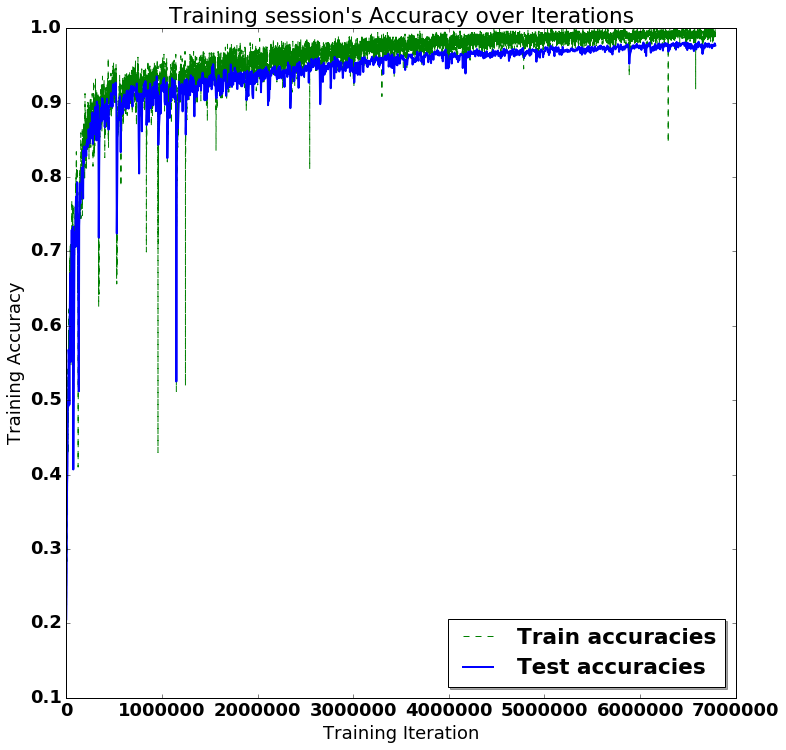

Testing Accuracy: 97.6525843143%

Precision: 97.639943676%
Recall: 97.6525821596%
f1_score: 97.6427318211%

Confusion Matrix:
Created using test set of 5751 datapoints, normalised to % of each class in the test dataset


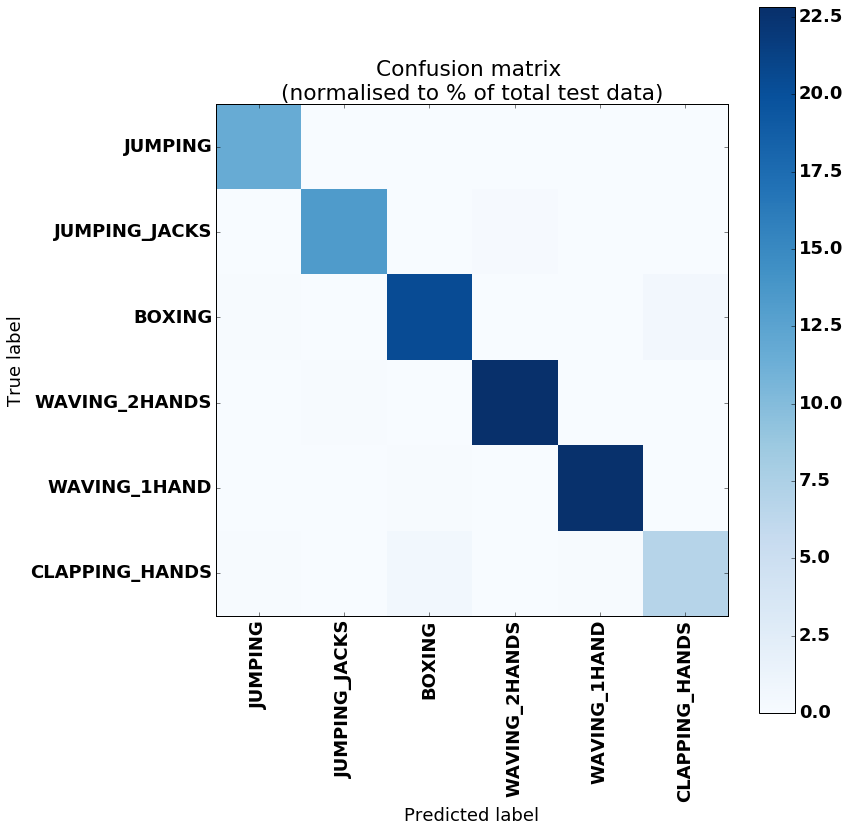

In [8]:
# (Inline plots: )
%matplotlib inline

font = {
    'family' : 'Bitstream Vera Sans',
    'weight' : 'bold',
    'size'   : 18
}
matplotlib.rc('font', **font)

width = 12
height = 12
plt.figure(figsize=(width, height))

indep_train_axis = np.array(range(batch_size, (len(train_losses)+1)*batch_size, batch_size))
#plt.plot(indep_train_axis, np.array(train_losses),     "b--", label="Train losses")
plt.plot(indep_train_axis, np.array(train_accuracies), "g--", label="Train accuracies")

indep_test_axis = np.append(
    np.array(range(batch_size, len(test_losses)*display_iter, display_iter)[:-1]),
    [training_iters]
)
#plt.plot(indep_test_axis, np.array(test_losses), "b-", linewidth=2.0, label="Test losses")
plt.plot(indep_test_axis, np.array(test_accuracies), "b-", linewidth=2.0, label="Test accuracies")
print len(test_accuracies)
print len(train_accuracies)

plt.title("Training session's Accuracy over Iterations")
plt.legend(loc='lower right', shadow=True)
plt.ylabel('Training Accuracy')
plt.xlabel('Training Iteration')

plt.show()

# Results

predictions = one_hot_predictions.argmax(1)

print("Testing Accuracy: {}%".format(100*accuracy))

print("")
print("Precision: {}%".format(100*metrics.precision_score(y_test, predictions, average="weighted")))
print("Recall: {}%".format(100*metrics.recall_score(y_test, predictions, average="weighted")))
print("f1_score: {}%".format(100*metrics.f1_score(y_test, predictions, average="weighted")))

print("")
print("Confusion Matrix:")
print("Created using test set of {} datapoints, normalised to % of each class in the test dataset".format(len(y_test)))
confusion_matrix = metrics.confusion_matrix(y_test, predictions)


#print(confusion_matrix)
normalised_confusion_matrix = np.array(confusion_matrix, dtype=np.float32)/np.sum(confusion_matrix)*100


# Plot Results: 
width = 12
height = 12
plt.figure(figsize=(width, height))
plt.imshow(
    normalised_confusion_matrix, 
    interpolation='nearest', 
    cmap=plt.cm.Blues
)
plt.title("Confusion matrix \n(normalised to % of total test data)")
plt.colorbar()
tick_marks = np.arange(n_classes)
plt.xticks(tick_marks, LABELS, rotation=90)
plt.yticks(tick_marks, LABELS)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


In [9]:
#
#X_val_path = DATASET_PATH + "X_val.txt"
#X_val = load_X(X_val_path)
#print X_val
#
#preds = sess.run(
#    [pred],
#    feed_dict={
#        x: X_val
#   }
#)
#
#print preds

In [10]:
#sess.close()
print test_accuracies

[0.20552947, 0.26221526, 0.38393322, 0.40723354, 0.49765259, 0.49121892, 0.56790125, 0.56077206, 0.49400103, 0.61328465, 0.67049211, 0.61293685, 0.55173016, 0.68179446, 0.72874284, 0.65988523, 0.66353679, 0.73308992, 0.40688577, 0.5256477, 0.60511214, 0.71952707, 0.72543907, 0.70631194, 0.75430357, 0.77360457, 0.75169533, 0.71726656, 0.79290557, 0.70613807, 0.72143978, 0.60858983, 0.51191097, 0.73413318, 0.7544775, 0.79116678, 0.76473659, 0.7904712, 0.78229874, 0.79881757, 0.81255436, 0.80681622, 0.8057729, 0.77099633, 0.83602852, 0.81898803, 0.84107113, 0.8372457, 0.83324641, 0.82768214, 0.83985394, 0.82837766, 0.84489655, 0.84194052, 0.85011303, 0.84054947, 0.84611374, 0.86402363, 0.85532951, 0.84507042, 0.85828549, 0.86228484, 0.8727178, 0.87080508, 0.86054599, 0.85202575, 0.86263257, 0.88680232, 0.84454876, 0.87358719, 0.87671709, 0.86767519, 0.85741609, 0.85880715, 0.89427924, 0.88315076, 0.88993222, 0.84924358, 0.90140843, 0.88332462, 0.86576247, 0.89671361, 0.88819337, 0.7184837

## Conclusion

Final accuracy of >90% is pretty good, considering that training takes about 7 minutes.

Noticeable confusion between activities of Clapping Hands and Boxing, and between Jumping Jacks and Waving Two Hands which is understandable.

In terms of the applicability of this to a wider dataset, I would imagine that it would be able to work for any activities in which the training included a views from all angles to be tested on. It would be interesting to see it's applicability to camera angles in between the 4 used in this dataset, without training on them specifically.

 Overall, this experiment validates the idea that 2D pose can be used for at least human activity recognition, and provides verification to continue onto use of 2D pose for behaviour estimation in both people and animals
 

 ### With regards to Using LSTM-RNNs
 - Batch sampling
     - It is neccessary to ensure you are not just sampling classes one at a time! (ie y_train is ordered by class and batch chosen in order)The use of random sampling of batches without replacement from the training data resolves this.    
 
 - Architecture
     - Testing has been run using a variety of hidden units per LSTM cell, with results showing that testing accuracy achieves a higher score when using a number of hidden cells approximately equal to that of the input, ie 34. The following figure displays the final accuracy achieved on the testing dataset for a variety of hidden units, all using a batch size of 4096 and 300 epochs (a total of 1657 iterations, with testing performed every 8th iteration).
   
 
 

## Future Works

Inclusion of :

 - A pipeline for qualitative results
 - A validation dataset
 - Momentum     
 - Normalise input data (each point with respect to distribution of itself only)
 - Dropout
 - Comparison of effect of changing batch size
 

Further research will be made into the use on more subtle activity classes, such as walking versus running, agitated movement versus calm movement, and perhaps normal versus abnormal behaviour, based on a baseline of normal motion.


## References

The dataset can be found at http://tele-immersion.citris-uc.org/berkeley_mhad released under the BSD-2 license
>Copyright (c) 2013, Regents of the University of California All rights reserved.

The network used in this experiment is based on the following, available under the [MIT License](https://github.com/guillaume-chevalier/LSTM-Human-Activity-Recognition/blob/master/LICENSE). :
> Guillaume Chevalier, LSTMs for Human Activity Recognition, 2016
> https://github.com/guillaume-chevalier/LSTM-Human-Activity-Recognition



In [11]:
# Let's convert this notebook to a README for the GitHub project's title page:
!jupyter nbconvert --to markdown LSTM.ipynb
!mv LSTM.md README.md

[NbConvertApp] Converting notebook LSTM.ipynb to markdown
[NbConvertApp] Writing 303430 bytes to LSTM.md


## 